Dataset shape: (1000, 20)

Column names:
 Index(['Solar_Power_kW', 'Solar_Irradiance_Wm2', 'Battery_SOC_%',
       'Num_EVs_Charging', 'Charging_Power_kW', 'Charging_Duration_Min',
       'Arrival_Time_Hour', 'Departure_Time_Hour', 'Initial_Battery_SOC_%',
       'Final_Battery_SOC_%', 'Charging_Mode', 'Grid_Energy_Supply_kW',
       'Residential_Load_kW', 'Business_Load_kW', 'Peak_Load_Time_Hour',
       'Energy_Cost_$/kWh', 'Demand_Response', 'Total_Demand_kW',
       'Available_Energy_kW', 'Optimal_Charging_Decision'],
      dtype='object')

First 5 rows:
   Solar_Power_kW  Solar_Irradiance_Wm2  Battery_SOC_%  Num_EVs_Charging  \
0       18.727006            266.619636      33.553512                 2   
1       47.535715            587.710853      32.228092                 8   
2       36.599697            885.651252      91.562912                 4   
3       29.932924            759.002398      32.459158                 7   
4        7.800932            825.905033      34.475475 

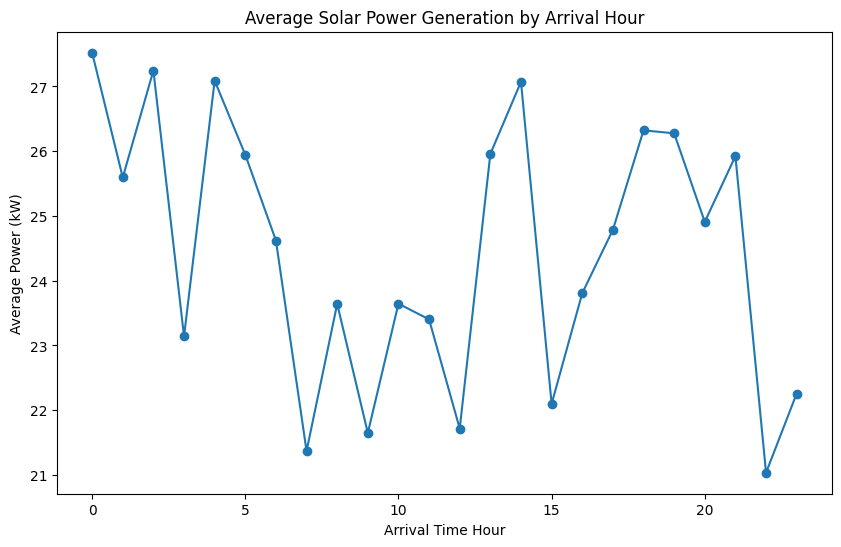

Training features shape: (800, 18)
Testing features shape: (200, 18)
Training target shape: (800,)
Testing target shape: (200,)
Test Mean Squared Error: 9.3900
Test R^2 Score: 0.7662


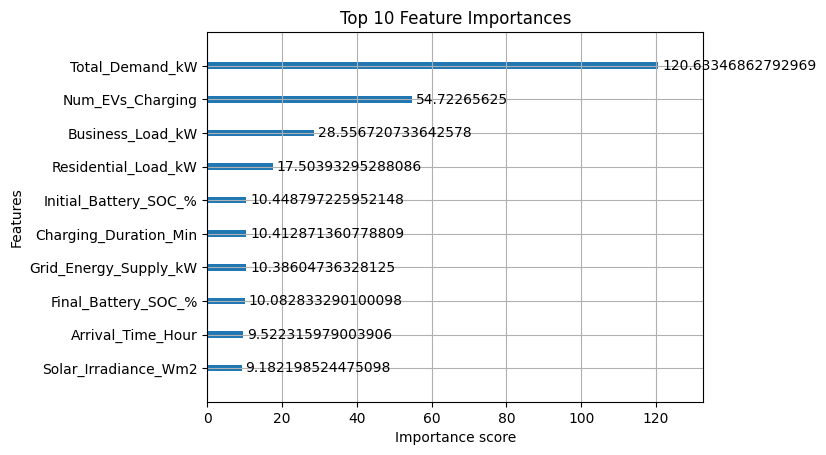

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
df = pd.read_csv('PV_EV_Charging_Dataset.csv')
print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values per column:")
print(df.isnull().sum())
print(df.info())

hourly_avg = df.groupby('Arrival_Time_Hour')['Solar_Power_kW'].mean()
plt.figure(figsize=(10,6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('Average Solar Power Generation by Arrival Hour')
plt.xlabel('Arrival Time Hour')
plt.ylabel('Average Power (kW)')
plt.show()

df = pd.get_dummies(df, columns=['Charging_Mode'], drop_first=True)
feature_cols = [col for col in df.columns if col != 'Charging_Power_kW' and col != 'Optimal_Charging_Decision']
X = df[feature_cols]
y = df['Charging_Power_kW']

split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index,:], X.iloc[split_index:,:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")


import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10, importance_type='gain', title='Top 10 Feature Importances')
plt.show()



In [4]:
import pandas as pd
df = pd.read_csv('PV_EV_Charging_Dataset.csv')

if df.isnull().sum().sum() == 0:
    print("No missing values found.")
else:
    
    df.fillna(df.median(numeric_only=True), inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)


df['Charging_Mode'] = df['Charging_Mode'].astype('category')


duplicates_count = df.duplicated().sum()
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Removed {duplicates_count} duplicate rows.")
else:
    print("No duplicate rows found.")



power_cols = ['Solar_Power_kW', 'Charging_Power_kW', 'Grid_Energy_Supply_kW', 'Available_Energy_kW']
for col in power_cols:
    df = df[df[col] >= 0]


df['Charging_Duration_Hours'] = df['Charging_Duration_Min'] / 60


df.to_csv('PV_EV_Charging_Cleaned.csv', index=False)
print("Cleaned dataset saved as PV_EV_Charging_Cleaned.csv")


No missing values found.
No duplicate rows found.
Cleaned dataset saved as PV_EV_Charging_Cleaned.csv
